In [2]:
from google.colab import drive
import os
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import json
import random
import time
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Kết nối với Google Drive
drive.mount('/content/drive')

project_dir = "/content/drive/MyDrive/Project_Gki"
os.makedirs(project_dir, exist_ok=True)
print("Nội dung trong Project_Gki:")
print(os.listdir(project_dir))

# Giải nén dữ liệu nếu có
zip_path = os.path.join(project_dir, "StanfordCars.zip")
print("Đường dẫn zip:", zip_path)
print("Tồn tại file zip?", os.path.exists(zip_path))

if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content/stanford_cars")
    print("Đã giải nén StanfordCars.zip")
else:
    print("File zip không tồn tại!")

Mounted at /content/drive
Nội dung trong Project_Gki:
['StanfordCars.zip', 'Copy of Gki_Stanford_Cars.ipynb']
Đường dẫn zip: /content/drive/MyDrive/Project_Gki/StanfordCars.zip
Tồn tại file zip? True
Đã giải nén StanfordCars.zip


In [3]:
# Phần 2: Tạo dữ liệu sử dụng mô hình VQA (BLIP)
!pip install transformers pillow torch

from transformers import BlipProcessor, BlipForQuestionAnswering


# Tải mô hình BLIP
print("Đang tải mô hình BLIP...")
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

# Chuyển mô hình sang GPU nếu có
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Sử dụng thiết bị: {device}")

# Định nghĩa danh sách câu hỏi cố định
question_templates = [
    "How many cars are in the image?",
    "What is the color of the car?",
    "What type of car is this?",
    "What brand is this car?",
    "Where is the car located?"
]

# Ánh xạ sang tiếng Việt
question_translations = {
    "How many cars are in the image?": "Có bao nhiêu xe trong ảnh?",
    "What is the color of the car?": "Màu sắc của xe là gì?",
    "What type of car is this?": "Đây là loại xe gì?",
    "What brand is this car?": "Xe này được sản xuất bởi hãng nào?",
    "Where is the car located?": "Xe trong ảnh đang ở đâu?"
}

def simple_translate(text):
    """Hàm dịch đơn giản cho một số câu trả lời phổ biến"""
    translations = {
        "one": "một",
        "two": "hai",
        "three": "ba",
        "four": "bốn",
        "five": "năm",
        "car": "xe",
        "red": "đỏ",
        "blue": "xanh dương",
        "green": "xanh lá",
        "black": "đen",
        "white": "trắng",
        "silver": "bạc",
        "gray": "xám",
        "yellow": "vàng",
        "sedan": "sedan",
        "suv": "SUV",
        "sports car": "xe thể thao",
        "truck": "xe tải",
        "toyota": "Toyota",
        "honda": "Honda",
        "bmw": "BMW",
        "mercedes": "Mercedes",
        "audi": "Audi",
        "ford": "Ford",
        "yes": "có",
        "no": "không",
        "street": "đường phố",
        "parking lot": "bãi đỗ xe",
        "garage": "garage",
        "parked": "đỗ",
        "moving": "di chuyển"
    }

    # Chuyển text về chữ thường để dễ tìm kiếm
    text_lower = text.lower()

    # Thử tìm và thay thế các từ/cụm từ có trong từ điển
    for en, vi in translations.items():
        if en in text_lower:
            text_lower = text_lower.replace(en, vi)

    # Tạo câu trả lời hoàn chỉnh
    if "xe" not in text_lower and "chiếc" not in text_lower and any(keyword in text_lower for keyword in ["một", "hai", "ba", "bốn", "năm"]):
        text_lower = text_lower.replace("một", "một chiếc xe")
        text_lower = text_lower.replace("hai", "hai chiếc xe")
        text_lower = text_lower.replace("ba", "ba chiếc xe")

    # Capitalize first letter
    if len(text_lower) > 0:
        text_lower = text_lower[0].upper() + text_lower[1:]

    # Thêm dấu chấm nếu chưa có
    if len(text_lower) > 0 and text_lower[-1] not in [".", "!", "?"]:
        text_lower += "."

    return text_lower

def generate_qa_with_vqa_model(image_path):
    """Sử dụng mô hình VQA để trả lời các câu hỏi định sẵn"""
    try:
        # Đọc hình ảnh
        image = Image.open(image_path).convert('RGB')
        filename = os.path.basename(image_path)

        qa_pairs = []

        # Đặt câu hỏi và lấy câu trả lời
        for question_en in question_templates:
            # Xử lý câu hỏi và hình ảnh
            inputs = processor(image, question_en, return_tensors="pt").to(device)

            # Lấy câu trả lời
            with torch.no_grad():
                outputs = model.generate(**inputs)
                answer_en = processor.decode(outputs[0], skip_special_tokens=True)

            # Thêm vào danh sách kết quả với câu hỏi tiếng Việt
            question_vi = question_translations[question_en]

            # Dịch câu trả lời sang tiếng Việt
            answer_vi = simple_translate(answer_en)

            qa_pairs.append({
                "image": filename,
                "question": question_vi,
                "answer": answer_vi
            })

        return qa_pairs

    except Exception as e:
        print(f"Lỗi khi xử lý ảnh {image_path}: {str(e)}")
        # Trả về câu hỏi-câu trả lời mặc định nếu có lỗi
        return [{"image": os.path.basename(image_path),
                "question": "Có bao nhiêu xe trong ảnh?",
                "answer": "Có một chiếc xe trong ảnh."}]

def create_dataset_with_vqa(image_dir, output_file, sample_size=None):
    """Tạo bộ dữ liệu từ thư mục hình ảnh sử dụng mô hình VQA"""
    all_qa_pairs = []

    # Kiểm tra thư mục tồn tại
    if not os.path.exists(image_dir):
        print(f"Thư mục {image_dir} không tồn tại!")
        return

    # Lấy tất cả các file hình ảnh
    image_files = [f for f in os.listdir(image_dir)
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not image_files:
        print(f"Không tìm thấy hình ảnh nào trong thư mục {image_dir}")
        return

    # Nếu có giới hạn số lượng mẫu
    if sample_size and sample_size < len(image_files):
        image_files = random.sample(image_files, sample_size)

    print(f"Đang tạo bộ dữ liệu từ {len(image_files)} hình ảnh...")

    # Xử lý từng hình ảnh
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(image_dir, image_file)
        print(f"Đang xử lý ảnh {i+1}/{len(image_files)}: {image_file}")

        # Sử dụng mô hình VQA để sinh câu trả lời
        qa_pairs = generate_qa_with_vqa_model(image_path)
        all_qa_pairs.extend(qa_pairs)

        # Lưu kết quả tạm thời sau mỗi 10 hình ảnh
        if (i + 1) % 10 == 0:
            with open(output_file + "_temp.json", 'w', encoding='utf-8') as f:
                json.dump(all_qa_pairs, f, ensure_ascii=False, indent=2)

    # Lưu vào file JSON
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(all_qa_pairs, f, ensure_ascii=False, indent=2)

    print(f"Đã tạo {len(all_qa_pairs)} cặp câu hỏi-trả lời trong file {output_file}")
    return all_qa_pairs

# Chỉ tạo dữ liệu với 100 ảnh đầu tiên để tiết kiệm thời gian
IMAGE_DIR = "/content/stanford_cars/cars_train/cars_train"
OUTPUT_FILE = "/content/questions_answers_vqa.json"
qa_pairs = create_dataset_with_vqa(IMAGE_DIR, OUTPUT_FILE, sample_size=100)

Đang tải mô hình BLIP...
Sử dụng thiết bị: cuda
Đang tạo bộ dữ liệu từ 100 hình ảnh...
Đang xử lý ảnh 1/100: 04433.jpg
Đang xử lý ảnh 2/100: 06033.jpg
Đang xử lý ảnh 3/100: 05034.jpg
Đang xử lý ảnh 4/100: 06444.jpg
Đang xử lý ảnh 5/100: 06470.jpg
Đang xử lý ảnh 6/100: 05567.jpg
Đang xử lý ảnh 7/100: 04441.jpg
Đang xử lý ảnh 8/100: 04777.jpg
Đang xử lý ảnh 9/100: 07830.jpg
Đang xử lý ảnh 10/100: 02258.jpg
Đang xử lý ảnh 11/100: 07937.jpg
Đang xử lý ảnh 12/100: 05105.jpg
Đang xử lý ảnh 13/100: 05044.jpg
Đang xử lý ảnh 14/100: 04167.jpg
Đang xử lý ảnh 15/100: 02075.jpg
Đang xử lý ảnh 16/100: 05208.jpg
Đang xử lý ảnh 17/100: 01731.jpg
Đang xử lý ảnh 18/100: 05294.jpg
Đang xử lý ảnh 19/100: 07558.jpg
Đang xử lý ảnh 20/100: 03237.jpg
Đang xử lý ảnh 21/100: 06579.jpg
Đang xử lý ảnh 22/100: 01201.jpg
Đang xử lý ảnh 23/100: 07674.jpg
Đang xử lý ảnh 24/100: 01356.jpg
Đang xử lý ảnh 25/100: 00538.jpg
Đang xử lý ảnh 26/100: 06793.jpg
Đang xử lý ảnh 27/100: 07824.jpg
Đang xử lý ảnh 28/100: 03228.jp

In [4]:
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
# Phần 3: Xây dựng mô hình VQA với CNN và LSTM
# Transform ảnh
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_image(image_path):
    try:
        image = Image.open(image_path).convert('RGB')
        return transform(image)
    except Exception as e:
        print(f"Lỗi khi tải hình ảnh {image_path}: {e}")
        # Trả về tensor trống nếu không tải được hình ảnh
        return torch.zeros(3, 224, 224)

# Xây dựng từ điển
def build_vocab(data):
    vocab = set()
    for item in data:
        vocab.update(item['question'].split())
        vocab.update(item['answer'].split())
    vocab = ['<PAD>', '<UNK>', '<START>', '<END>'] + list(vocab)
    return {word: idx for idx, word in enumerate(vocab)}, {idx: word for idx, word in enumerate(vocab)}

# Dataset
class QADataset(Dataset):
    def __init__(self, data, word2idx, image_dir):
        self.data = data
        self.word2idx = word2idx
        self.image_dir = image_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = os.path.join(self.image_dir, item['image'])
        image = load_image(image_path)

        # Chuyển câu hỏi thành token
        question = [self.word2idx.get(word, self.word2idx['<UNK>']) for word in item['question'].split()]

        # Chuyển câu trả lời thành token
        answer = [self.word2idx['<START>']] + [self.word2idx.get(word, self.word2idx['<UNK>'])
                                              for word in item['answer'].split()] + [self.word2idx['<END>']]

        return image, torch.tensor(question), torch.tensor(answer)

def collate_fn(batch):
    images, questions, answers = zip(*batch)
    images = torch.stack(images)
    questions = nn.utils.rnn.pad_sequence(questions, batch_first=True, padding_value=0)
    answers = nn.utils.rnn.pad_sequence(answers, batch_first=True, padding_value=0)
    return images, questions, answers

def prepare_dataloaders(data_file, image_dir, batch_size=32):
    # Đọc dữ liệu
    try:
        with open(data_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"File dữ liệu {data_file} không tồn tại!")
        return None, None, None, None, None

    # Xây dựng từ điển
    word2idx, idx2word = build_vocab(data)
    vocab_size = len(word2idx)

    # Chia dữ liệu
    train_size = int(0.8 * len(data))
    val_size = int(0.1 * len(data))

    train_data = data[:train_size]
    val_data = data[train_size:train_size + val_size]
    test_data = data[train_size + val_size:]

    # Tạo datasets
    train_dataset = QADataset(train_data, word2idx, image_dir)
    val_dataset = QADataset(val_data, word2idx, image_dir)
    test_dataset = QADataset(test_data, word2idx, image_dir)

    # Tạo dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        collate_fn=collate_fn
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=1,  # Để dễ xử lý, batch_size cho test_loader là 1
        collate_fn=collate_fn
    )

    return train_loader, val_loader, test_loader, word2idx, idx2word

# CNN Encoder (với lựa chọn pretrained hoặc train từ đầu)
class CNNEncoder(nn.Module):
    def __init__(self, embed_size=512, pretrained=True):
        super(CNNEncoder, self).__init__()
        if pretrained:
            cnn = models.resnet50(pretrained=True)
            # Đóng băng các tham số nếu sử dụng pretrained
            for param in cnn.parameters():
                param.requires_grad = False
        else:
            # Train từ đầu
            cnn = models.resnet50(pretrained=False)

        self.cnn = nn.Sequential(*list(cnn.children())[:-1])
        self.fc = nn.Linear(2048, embed_size)

    def forward(self, images):
        features = self.cnn(images)
        features = features.view(features.size(0), -1)
        features = self.fc(features)
        return features

# Bộ mã hóa câu hỏi
class QuestionEncoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(QuestionEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, hidden_size)

    def forward(self, questions):
        embeddings = self.embedding(questions)
        outputs, (hidden, cell) = self.lstm(embeddings)
        features = self.fc(hidden.squeeze(0))
        return outputs, features

# LSTM Decoder với Attention
class AttentionLSTMDecoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super(AttentionLSTMDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.attention = nn.Linear(embed_size + hidden_size, hidden_size)
        self.attention_combine = nn.Linear(hidden_size * 2 + embed_size, embed_size)
        self.lstm = nn.LSTM(embed_size + hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, img_features, q_features, captions):
        batch_size = captions.size(0)
        embeddings = self.embedding(captions)

        # Kết hợp đặc trưng câu hỏi với đặc trưng hình ảnh
        combined_features = torch.cat((img_features, q_features), dim=1)
        context = self.attention(combined_features)

        # Lặp lại ngữ cảnh cho mỗi từ trong chuỗi
        context = context.unsqueeze(1).repeat(1, embeddings.size(1), 1)

        # Nối embeddings và ngữ cảnh
        lstm_input = torch.cat((embeddings, context), dim=2)

        # LSTM và đầu ra
        hiddens, _ = self.lstm(lstm_input)
        outputs = self.fc(hiddens)
        return outputs

# LSTM Decoder không có Attention
class BasicLSTMDecoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super(BasicLSTMDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size + embed_size + hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, img_features, q_features, captions):
        embeddings = self.embedding(captions)

        # Kết hợp đặc trưng
        combined_features = torch.cat((img_features, q_features), dim=1)

        # Lặp lại cho mỗi từ
        features = combined_features.unsqueeze(1).repeat(1, embeddings.size(1), 1)
        inputs = torch.cat((features, embeddings), dim=2)

        # LSTM và đầu ra
        hiddens, _ = self.lstm(inputs)
        outputs = self.fc(hiddens)
        return outputs

# Mô hình VQA hoàn chỉnh
class VQAModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, use_pretrained=True, use_attention=True):
        super(VQAModel, self).__init__()
        self.cnn = CNNEncoder(embed_size, pretrained=use_pretrained)
        self.question_encoder = QuestionEncoder(vocab_size, embed_size, hidden_size)

        if use_attention:
            self.decoder = AttentionLSTMDecoder(embed_size, hidden_size, vocab_size)
        else:
            self.decoder = BasicLSTMDecoder(embed_size, hidden_size, vocab_size)

        self.use_attention = use_attention

    def forward(self, images, questions, answers=None):
        img_features = self.cnn(images)
        q_outputs, q_features = self.question_encoder(questions)

        if answers is not None:
            # Chế độ huấn luyện - teacher forcing
            outputs = self.decoder(img_features, q_features, answers[:, :-1])
            return outputs
        else:
            # Chế độ suy luận
            return img_features, q_features

In [5]:
import time

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Huấn luyện mô hình qua 1 epoch"""
    model.train()
    total_loss = 0.0
    start_time = time.time()

    for i, (images, questions, answers) in enumerate(train_loader):
        images = images.to(device)
        questions = questions.to(device)
        answers = answers.to(device)

        # Forward pass
        outputs = model(images, questions, answers)

        # Tính loss (bỏ qua padding)
        loss = criterion(outputs.reshape(-1, outputs.size(-1)), answers[:, 1:].reshape(-1))

        # Backward pass và optimize
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)  # Gradient clipping
        optimizer.step()

        total_loss += loss.item()

        # In tiến trình
        if (i + 1) % 10 == 0:
            print(f"Batch {i+1}/{len(train_loader)}, Loss: {loss.item():.4f}, "
                  f"Time: {time.time() - start_time:.2f}s")
            start_time = time.time()

    return total_loss / len(train_loader)


def validate(model, val_loader, criterion, device):
    """Đánh giá mô hình trên tập validation"""
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for images, questions, answers in val_loader:
            images = images.to(device)
            questions = questions.to(device)
            answers = answers.to(device)

            # Forward pass
            outputs = model(images, questions, answers)

            # Tính loss
            loss = criterion(outputs.reshape(-1, outputs.size(-1)), answers[:, 1:].reshape(-1))
            total_loss += loss.item()

    return total_loss / len(val_loader)

In [6]:
def generate_answer(model, image, question, word2idx, idx2word, device, max_len=20):
    """Sinh câu trả lời từ mô hình"""
    model.eval()
    with torch.no_grad():
        # Chuẩn bị đầu vào
        image = image.unsqueeze(0).to(device)
        question = torch.tensor([word2idx.get(word, word2idx['<UNK>'])
                                for word in question.split()]).unsqueeze(0).to(device)

        # Lấy đặc trưng
        img_features, q_features = model(image, question)

        # Sinh câu trả lời
        answer = [word2idx['<START>']]
        for i in range(max_len):
            # Chuyển đổi chuỗi hiện tại thành tensor
            current_answer = torch.tensor([answer]).to(device)

            # Dự đoán từ tiếp theo
            output = model.decoder(img_features, q_features, current_answer)

            # Lấy từ có khả năng cao nhất tiếp theo
            _, next_word_idx = output[:, -1].max(1)
            next_word_idx = next_word_idx.item()

            # Thêm vào chuỗi câu trả lời
            answer.append(next_word_idx)

            # Dừng nếu gặp token <END>
            if next_word_idx == word2idx['<END>']:
                break

        # Chuyển đổi chỉ số thành từ (bỏ qua <START> và <END>)
        words = [idx2word[idx] for idx in answer[1:-1] if idx in idx2word]
        return ' '.join(words)

Sử dụng thiết bị: cuda
Kích thước từ điển: 122


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/10
------------------------------
Batch 10/13, Loss: 2.8001, Time: 3.66s
Train Loss: 3.1122, Val Loss: 2.6563

Epoch 2/10
------------------------------
Batch 10/13, Loss: 1.9793, Time: 3.29s
Train Loss: 2.2509, Val Loss: 2.2031

Epoch 3/10
------------------------------
Batch 10/13, Loss: 1.8792, Time: 3.83s
Train Loss: 1.8281, Val Loss: 1.8423

Epoch 4/10
------------------------------
Batch 10/13, Loss: 1.3451, Time: 3.18s
Train Loss: 1.4940, Val Loss: 1.6316

Epoch 5/10
------------------------------
Batch 10/13, Loss: 1.1571, Time: 3.34s
Train Loss: 1.2719, Val Loss: 1.5168

Epoch 6/10
------------------------------
Batch 10/13, Loss: 1.0484, Time: 4.14s
Train Loss: 1.1448, Val Loss: 1.4740

Epoch 7/10
------------------------------
Batch 10/13, Loss: 1.0159, Time: 3.32s
Train Loss: 1.0555, Val Loss: 1.4370

Epoch 8/10
------------------------------
Batch 10/13, Loss: 0.9248, Time: 3.36s
Train Loss: 1.0123, Val Loss: 1.4269

Epoch 9/10
------------------------------
Batch

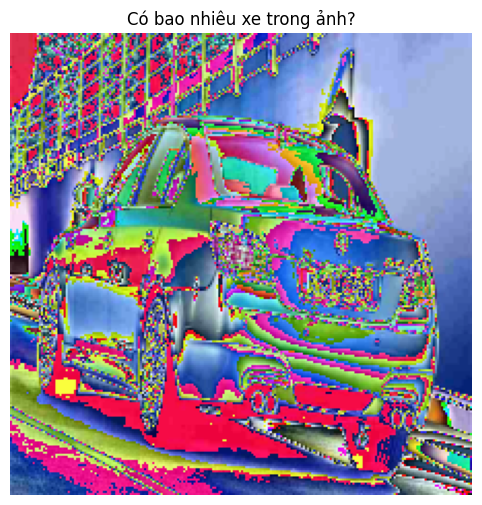

Câu hỏi: Có bao nhiêu xe trong ảnh?
Câu trả lời thực: Một chiếc xe.
Câu trả lời sinh: 1.



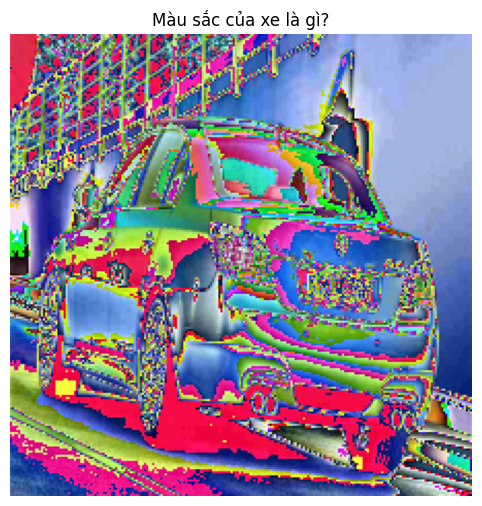

Câu hỏi: Màu sắc của xe là gì?
Câu trả lời thực: Bạc.
Câu trả lời sinh: Trắng.



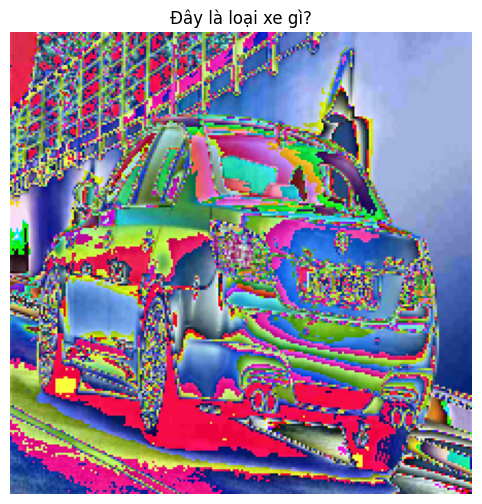

Câu hỏi: Đây là loại xe gì?
Câu trả lời thực: BMW.
Câu trả lời sinh: BMW.



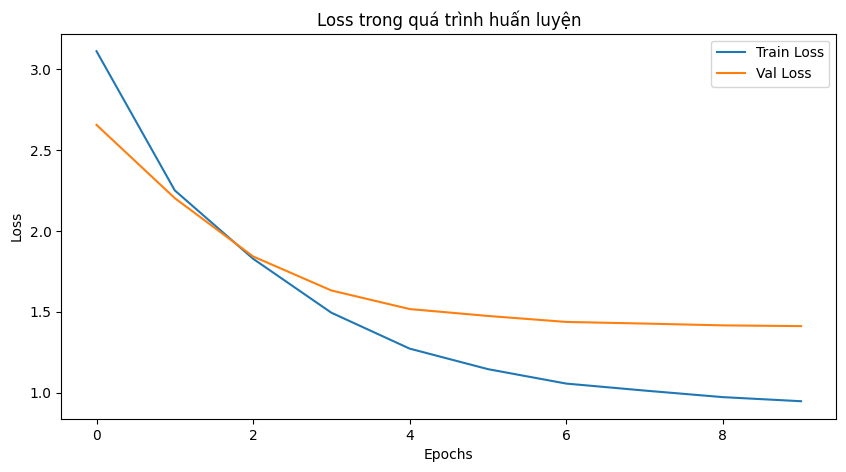

In [12]:
def train_single_model():
    """Huấn luyện một mô hình duy nhất để kiểm tra hiệu suất"""
    # Cấu hình
    CONFIG = {
        'embed_size': 256,
        'hidden_size': 512,
        'batch_size': 32,
        'epochs': 10,  # Tăng số lượng epoch để huấn luyện tốt hơn
        'learning_rate': 0.001,
        'image_dir': '/content/stanford_cars/cars_train/cars_train',
        'data_file': '/content/questions_answers_vqa.json',
        'save_dir': '/content/drive/MyDrive/Project_Gki',
        'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    }

    print(f"Sử dụng thiết bị: {CONFIG['device']}")

    # Chuẩn bị dữ liệu
    train_loader, val_loader, test_loader, word2idx, idx2word = prepare_dataloaders(
        CONFIG['data_file'],
        CONFIG['image_dir'],
        CONFIG['batch_size']
    )

    if train_loader is None:
        print("Không thể tải dữ liệu. Vui lòng kiểm tra lại đường dẫn dữ liệu.")
        return None, None, None, None

    vocab_size = len(word2idx)
    print(f"Kích thước từ điển: {vocab_size}")

    # Khởi tạo mô hình (pretrained CNN với Attention)
    model = VQAModel(
        embed_size=CONFIG['embed_size'],
        hidden_size=CONFIG['hidden_size'],
        vocab_size=vocab_size,
        use_pretrained=True,
        use_attention=True
    )

    model = model.to(CONFIG['device'])

    # Định nghĩa loss và optimizer
    criterion = nn.CrossEntropyLoss(ignore_index=word2idx['<PAD>'])
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'])  # Sử dụng AdamW
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    train_losses = []
    val_losses = []

    # Huấn luyện qua các epoch
    for epoch in range(CONFIG['epochs']):
        print(f"\nEpoch {epoch+1}/{CONFIG['epochs']}")
        print("-" * 30)

        # Huấn luyện
        train_loss = train_epoch(model, train_loader, criterion, optimizer, CONFIG['device'])
        train_losses.append(train_loss)

        # Kiểm tra
        val_loss = validate(model, val_loader, criterion, CONFIG['device'])
        val_losses.append(val_loss)

        # Điều chỉnh learning rate nếu cần
        scheduler.step(val_loss)

        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Lưu mô hình vào Google Drive
    model_save_path = os.path.join(CONFIG['save_dir'], "vqa_model.pth")
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'word2idx': word2idx,
        'idx2word': idx2word,
        'train_losses': train_losses,
        'val_losses': val_losses,
    }, model_save_path)
    print(f"Đã lưu mô hình tại {model_save_path}")

    # Test mô hình với một vài mẫu
    print("\nTest mô hình với một vài mẫu:")
    model.eval()
    for i, (image, question, answer) in enumerate(test_loader):
        if i >= 3:  # Chỉ hiển thị 3 ví dụ
            break

        image = image[0]
        question_text = ' '.join([idx2word[idx.item()] for idx in question[0] if idx.item() in idx2word])
        answer_text = ' '.join([idx2word[idx.item()] for idx in answer[0][1:-1] if idx.item() in idx2word])

        generated = generate_answer(model, image, question_text, word2idx, idx2word, CONFIG['device'])

        # Hiển thị ảnh
        plt.figure(figsize=(10, 6))
        img = transforms.ToPILImage()(image.cpu())
        plt.imshow(img)
        plt.title(question_text)
        plt.axis('off')
        plt.show()

        print(f"Câu hỏi: {question_text}")
        print(f"Câu trả lời thực: {answer_text}")
        print(f"Câu trả lời sinh: {generated}\n")

    # Vẽ biểu đồ loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss trong quá trình huấn luyện')
    plt.savefig(os.path.join(CONFIG['save_dir'], 'training_loss.png'))
    plt.show()

    return model, word2idx, idx2word, CONFIG

# Gọi hàm huấn luyện
model, word2idx, idx2word, CONFIG = train_single_model()

<ipython-input-14-1013ba972939>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Đã tải mô hình thành công!


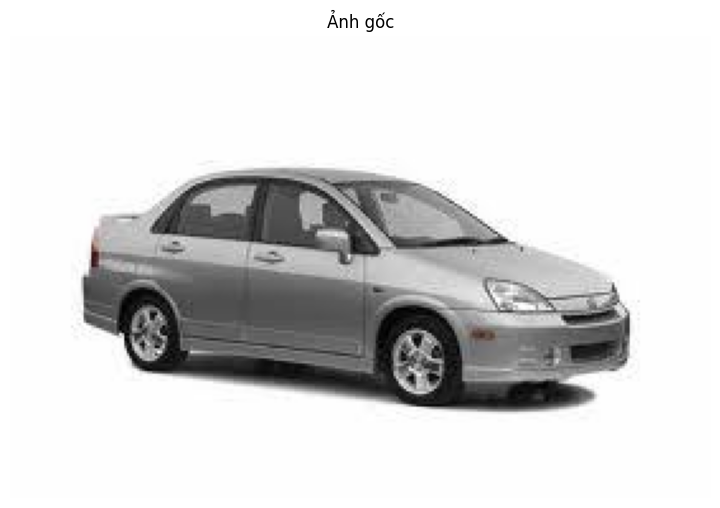

Câu hỏi: Có bao nhiêu xe trong ảnh?
Câu trả lời: 1.

Câu hỏi: Màu sắc của xe là gì?
Câu trả lời: Trắng.

Câu hỏi: Đây là loại xe gì?
Câu trả lời: BMW.

Câu hỏi: Xe này được sản xuất bởi hãng nào?
Câu trả lời: BMW.

Câu hỏi: Xe trong ảnh đang ở đâu?
Câu trả lời: On đường phố.



In [14]:
def load_model_from_drive():
    """Tải mô hình đã lưu từ Google Drive"""
    model_path = "/content/drive/MyDrive/Project_Gki/vqa_model.pth"

    if not os.path.exists(model_path):
        print(f"Không tìm thấy mô hình tại {model_path}")
        return None, None, None

    # Tải checkpoint
    checkpoint = torch.load(model_path)
    word2idx = checkpoint['word2idx']
    idx2word = checkpoint['idx2word']

    # Khởi tạo mô hình
    model = VQAModel(
        embed_size=256,
        hidden_size=512,
        vocab_size=len(word2idx),
        use_pretrained=True,
        use_attention=True
    )

    # Tải trọng số
    model.load_state_dict(checkpoint['model_state_dict'])
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    print("Đã tải mô hình thành công!")

    return model, word2idx, idx2word

def test_with_custom_image(model, word2idx, idx2word, image_path):
    """Test mô hình với một hình ảnh tùy chỉnh"""
    if model is None:
        print("Cần tải mô hình trước khi test!")
        return

    # Load and transform image
    image = load_image(image_path)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Display original image
    plt.figure(figsize=(10, 6))
    img = Image.open(image_path).convert('RGB')
    plt.imshow(img)
    plt.title("Ảnh gốc")
    plt.axis('off')
    plt.show()

    # Đặt các câu hỏi
    questions = [
        "Có bao nhiêu xe trong ảnh?",
        "Màu sắc của xe là gì?",
        "Đây là loại xe gì?",
        "Xe này được sản xuất bởi hãng nào?",
        "Xe trong ảnh đang ở đâu?"
    ]

    # Lấy câu trả lời
    for question in questions:
        answer = generate_answer(model, image, question, word2idx, idx2word, device)
        print(f"Câu hỏi: {question}")
        print(f"Câu trả lời: {answer}\n")

# Tải mô hình và test
loaded_model, word2idx, idx2word = load_model_from_drive()
if loaded_model is not None:
    # Thay đường dẫn bằng một hình ảnh xe bất kỳ
    test_image_path = "/content/stanford_cars/cars_test/cars_test/00001.jpg"
    test_with_custom_image(loaded_model, word2idx, idx2word, test_image_path)

<ipython-input-14-1013ba972939>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Đã tải mô hình thành công!


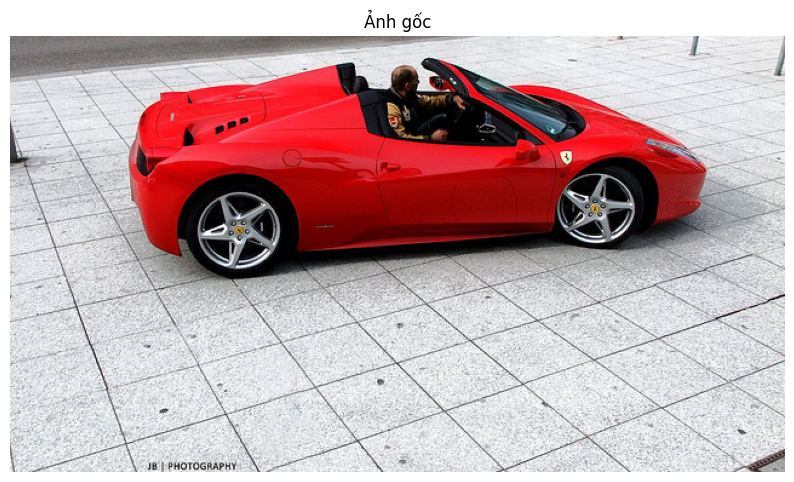

Câu hỏi: Có bao nhiêu xe trong ảnh?
Câu trả lời: 1.

Câu hỏi: Màu sắc của xe là gì?
Câu trả lời: Trắng.

Câu hỏi: Đây là loại xe gì?
Câu trả lời: Sedan.

Câu hỏi: Xe này được sản xuất bởi hãng nào?
Câu trả lời: BMW.

Câu hỏi: Xe trong ảnh đang ở đâu?
Câu trả lời: Bãi đỗ xe.



In [16]:
import matplotlib.pyplot as plt

def test_with_custom_image(model, word2idx, idx2word, image_path):
    """Test mô hình với một hình ảnh tùy chỉnh"""
    if model is None:
        print("Cần tải mô hình trước khi test!")
        return

    # Load and transform image
    image = load_image(image_path)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Display original image
    plt.figure(figsize=(10, 6))
    img = Image.open(image_path).convert('RGB')
    plt.imshow(img)
    plt.title("Ảnh gốc")
    plt.axis('off')
    plt.show()

    # Đặt các câu hỏi
    questions = [
        "Có bao nhiêu xe trong ảnh?",
        "Màu sắc của xe là gì?",
        "Đây là loại xe gì?",
        "Xe này được sản xuất bởi hãng nào?",
        "Xe trong ảnh đang ở đâu?"
    ]

    # Lấy câu trả lời
    for question in questions:
        answer = generate_answer(model, image, question, word2idx, idx2word, device)
        print(f"Câu hỏi: {question}")
        print(f"Câu trả lời: {answer}\n")

# Tải mô hình và test
loaded_model, word2idx, idx2word = load_model_from_drive()
if loaded_model is not None:
    # Thay đường dẫn bằng một hình ảnh xe bất kỳ
    test_image_path = "/content/stanford_cars/cars_test/cars_test/00002.jpg"
    test_with_custom_image(loaded_model, word2idx, idx2word, test_image_path)

Không dùng tới phần dưới